In [1]:
# Import necessary libraries
# - `geopandas` for geographic data manipulation
# - `matplotlib.pyplot` for visualization
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Load the Business Improvement Districts (BIDs) dataset
# `bid_data` includes geographic boundaries of BIDs across NYC.
bid_data = gpd.read_file('../common_files/NYC_BIDS_09112015.csv', encoding='utf-8')

In [3]:
bid_data.head()

,the_geom,Id,OBJECTID_1,OBJECTID_2,Shape_Leng,F_ALL_BIDs,F_ALL_BI_1,F_ALL_BI_2,F_ALL_BI_3,F_ALL_BI_4,F_ALL_BI_6,F_ALL_BI_7,Shape_Le_1,Shape_Ar_1,Year_Found,Shape_Area
0,MULTIPOLYGON (((-73.94296015325146 40.73949166...,0,0,0,0,0,Queens,Long Island City Partnership,0,https://www.longislandcityqueens.com/,0,0,0,0,2005,0
1,MULTIPOLYGON (((-73.89166191549769 40.67759930...,0,0,0,0,0,Brooklyn,Cypress Hills Fulton,0,https://cypresshillsfultonbid.org/,0,0,0,0,2023,0
2,MULTIPOLYGON (((-73.98282323348212 40.73130538...,0,0,1,0,0,Manhattan,Union Square Partnership,892,https://www.unionsquarenyc.org/,3400000,3950623,25744.4695903,1275270.53685,1984,206555.808776
3,MULTIPOLYGON (((-73.9419337956347 40.806137014...,0,0,2,0,0,Manhattan,125th Street,220,https://www.125thstreet.nyc/,1240462,1289475,18167.7930477,982675.507591,1994,159516.90573
4,MULTIPOLYGON (((-73.9188925538744 40.825078988...,0,0,3,0,1,Bronx,161st Street,145,http://www.161bid.com/,1687028,506873,16588.0134708,1303742.08624,2005,211748.007845


In [5]:
# load geojson file
kpfui_dev_data = gpd.read_file('./files/kpfui_dev.json')

In [15]:
bid_gdf = gpd.GeoDataFrame(
    bid_data,
    geometry=gpd.GeoSeries.from_wkt(bid_data['the_geom']),
)

In [16]:
# Filter for West Village BID
wv_bid = bid_gdf[bid_gdf['F_ALL_BI_2'] == 'West Village']
# Use `explode` to ensure each geometry component is in a separate row, simplifying spatial analysis
exploded_wv_data = wv_bid.explode()

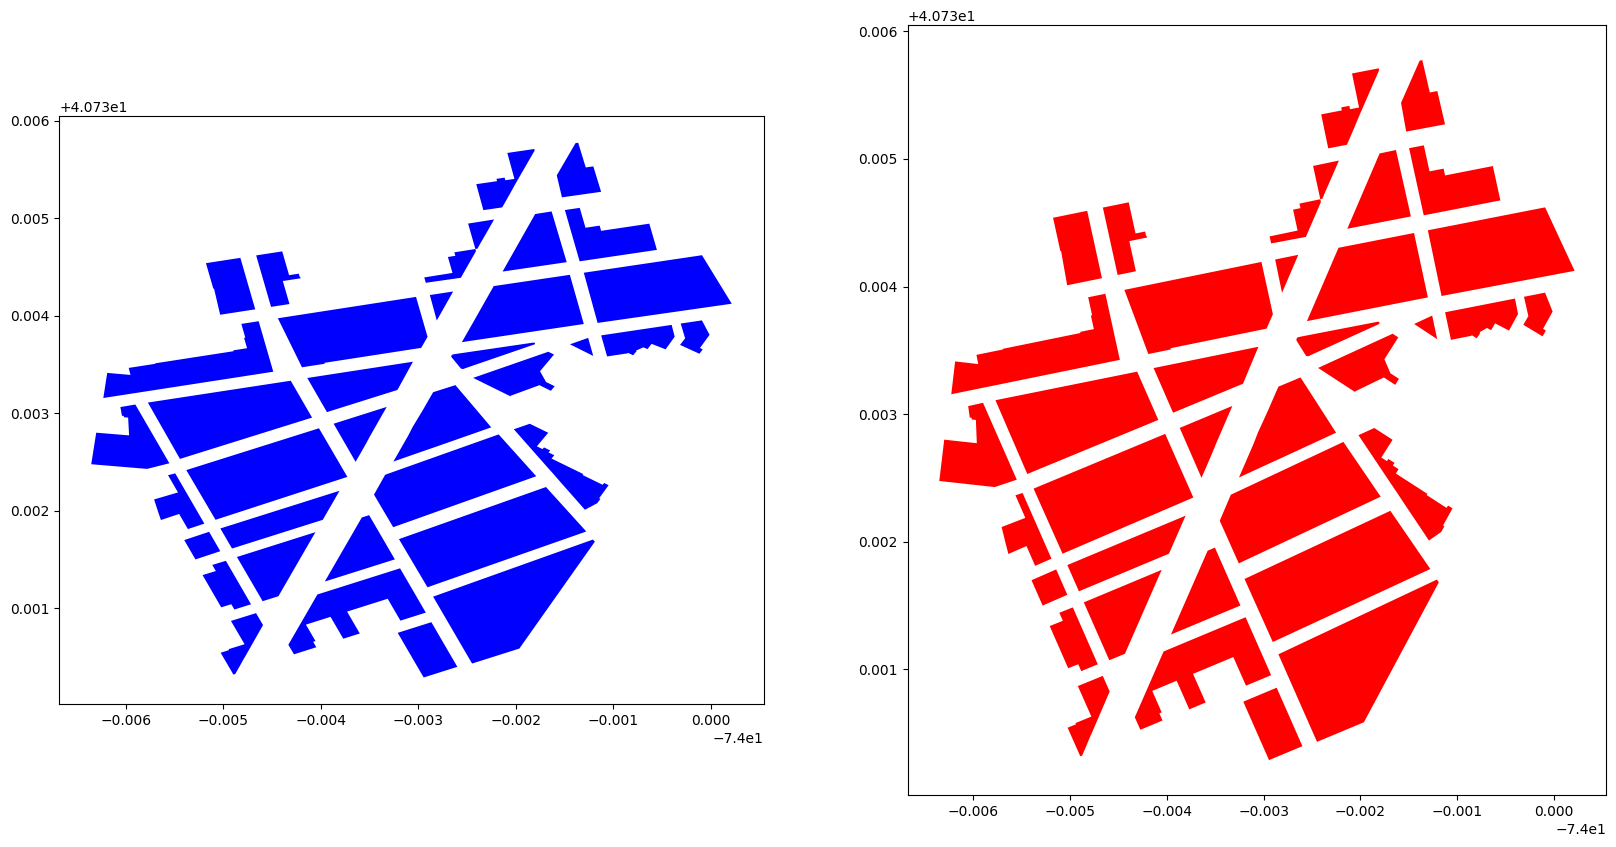

In [25]:
# plot the two datasets side by side
fig, ax = plt.subplots(1, 2,  figsize=(20, 10))

# plot the bid_data_objectid_2_0 geodataframe
wv_bid.plot(ax=ax[0], color='blue', markersize=.01)
# plot the exploded geodataframe
exploded_wv_data.plot(ax=ax[1], color='red', markersize=.01)
exploded_wv_data.set_crs(epsg=4326, inplace=True)
plt.show()

In [26]:
# Create a buffered version of the BID boundaries
# Buffer distance in degrees (for EPSG:4326) - adjust as needed
# ~0.0001 degrees is roughly 10-11 meters at NYC's latitude
buffer_distance = 0.0001  
buffered_wv_data = exploded_wv_data.copy()
buffered_wv_data['geometry'] = exploded_wv_data.geometry.buffer(buffer_distance)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_38960\662131454.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_wv_data['geometry'] = exploded_wv_data.geometry.buffer(buffer_distance)


In [27]:
# Spatial join directly without bbox filtering
kpfui_dev_within_bbox = gpd.sjoin(
    kpfui_dev_data, 
    buffered_wv_data, 
    how='inner', 
    predicate='intersects'
)
print("Number of sidewalks found:", len(kpfui_dev_within_bbox))

Number of sidewalks found: 329


C:\Users\ASUS\AppData\Local\Temp\ipykernel_38960\823117546.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


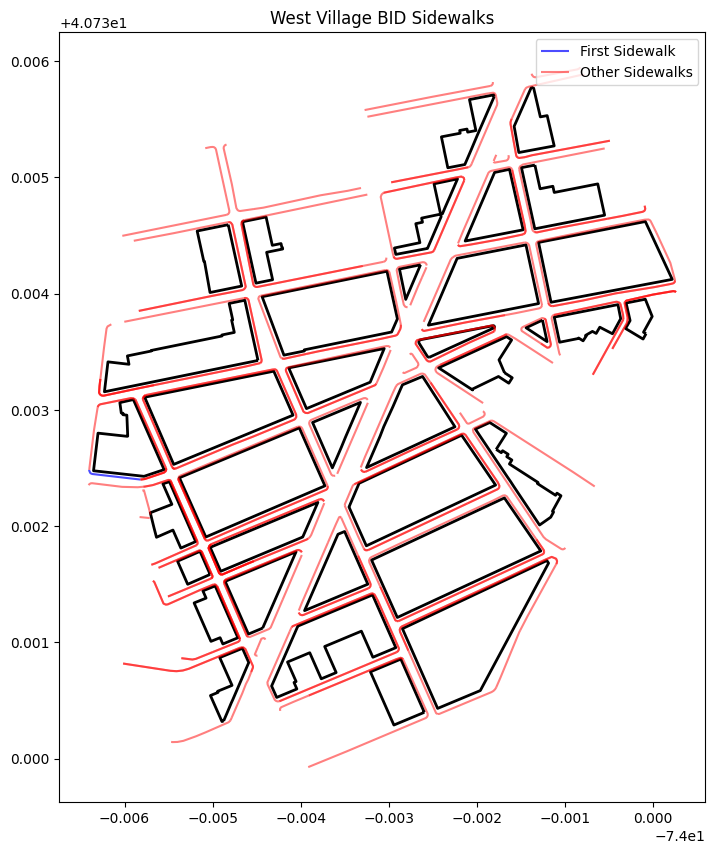

In [30]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the BID boundary
wv_bid.plot(ax=ax, color='none', edgecolor='black', linewidth=2, label='BID Boundary')

# Split the sidewalks dataframe into first row and rest
if len(kpfui_dev_within_bbox) > 0:
    first_row = kpfui_dev_within_bbox.iloc[[0]]
    rest_rows = kpfui_dev_within_bbox.iloc[1:] if len(kpfui_dev_within_bbox) > 1 else None
    
    # Plot the first row in blue
    first_row.plot(ax=ax, color='blue', alpha=0.7, label='First Sidewalk')
    
    # Plot the rest in red (if there are any)
    if rest_rows is not None and len(rest_rows) > 0:
        rest_rows.plot(ax=ax, color='red', alpha=0.5, label='Other Sidewalks')
else:
    print("No sidewalks found to plot")

# Add labels and title
plt.title('West Village BID Sidewalks')
plt.legend()

# Show the plot
plt.show()

In [34]:
# Save the processed sidewalk data as GeoJSON
kpfui_dev_within_bbox.to_file("./files/kpfui_dev_within_bbox.json", driver='GeoJSON')

# Save the BID boundary as GeoJSON
wv_bid.to_file("./files/wv_bid.json", driver='GeoJSON')

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyogrio\geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


In [32]:
kpfui_dev_within_bbox.head(1)

'{"type": "FeatureCollection", "features": [{"id": "1310", "type": "Feature", "properties": {"area": 1804.256, "p_total_9": 12, "area_p_9": 150.355, "p_walk_9": 12, "p_queue_9": 0, "rest_9": 0, "supe_9": 0, "phar_9": 0, "bank_9": 0, "offi_9": 0, "subw_9": 0, "p_total_12": 2, "area_p_12": 902.128, "p_walk_12": 2, "p_queue_12": 0, "rest_12": 0, "supe_12": 0, "phar_12": 0, "bank_12": 0, "offi_12": 0, "subw_12": 0, "p_total_19": 13, "area_p_19": 138.789, "p_walk_19": 13, "p_queue_19": 0, "rest_19": 0, "supe_19": 0, "phar_19": 0, "bank_19": 0, "offi_19": 0, "subw_19": 0, "index_right": 70, "the_geom": "MULTIPOLYGON (((-74.00259794395119 40.73039915334195, -74.00294323388853 40.73028989836621, -74.00308915263001 40.73054078440828, -74.00320954843765 40.73074778426883, -74.00286425670369 40.73085703917346, -74.00259794395119 40.73039915334195)), ((-74.00487541394492 40.73032585063584, -74.00489468011283 40.73031972811829, -74.00502566346441 40.730543747631664, -74.0049388062579 40.73057074134

In [33]:
# Get and display all column names
column_names = kpfui_dev_within_bbox.columns
print("Column names:")
for i, col in enumerate(column_names):
    print(f"{i+1}. {col}")

# You can also see the full structure of the first row
print("\nFirst row structure:")
first_row = kpfui_dev_within_bbox.iloc[0]
for col, value in first_row.items():
    print(f"{col}: {type(value)}")
    
    # For geometry objects, print additional info
    if col == 'geometry':
        print(f"  - Geometry type: {value.geom_type}")
        print(f"  - Bounds: {value.bounds}")

Column names:
1. area
2. p_total_9
3. area_p_9
4. p_walk_9
5. p_queue_9
6. rest_9
7. supe_9
8. phar_9
9. bank_9
10. offi_9
11. subw_9
12. p_total_12
13. area_p_12
14. p_walk_12
15. p_queue_12
16. rest_12
17. supe_12
18. phar_12
19. bank_12
20. offi_12
21. subw_12
22. p_total_19
23. area_p_19
24. p_walk_19
25. p_queue_19
26. rest_19
27. supe_19
28. phar_19
29. bank_19
30. offi_19
31. subw_19
32. geometry
33. index_right
34. the_geom
35. Id
36. OBJECTID_1
37. OBJECTID_2
38. Shape_Leng
39. F_ALL_BIDs
40. F_ALL_BI_1
41. F_ALL_BI_2
42. F_ALL_BI_3
43. F_ALL_BI_4
44. F_ALL_BI_6
45. F_ALL_BI_7
46. Shape_Le_1
47. Shape_Ar_1
48. Year_Found
49. Shape_Area

First row structure:
area: <class 'numpy.float64'>
p_total_9: <class 'numpy.int32'>
area_p_9: <class 'numpy.float64'>
p_walk_9: <class 'numpy.int32'>
p_queue_9: <class 'numpy.int32'>
rest_9: <class 'numpy.int32'>
supe_9: <class 'numpy.int32'>
phar_9: <class 'numpy.int32'>
bank_9: <class 'numpy.int32'>
offi_9: <class 'numpy.int32'>
subw_9: <clas